# Using Different Mixer Hamiltonians

One of the key features of QAOA is the alternate application of the cost and mixer hamiltonians. While the cost hamiltonian tends to be defined by the problem at hand, the choice of mixer hamiltonians is not as obvious. In OpenQAOA, we provide multiple utility functions that help create commonly used mixer hamiltonians, such as the X and XY mixer hamiltonians.

In this notebook, we provide the user with examples on how he can use these utility functions to quickly construct their mixer hamiltonians. Furthermore, we will introduce a feature in OpenQAOA, inspired by Hadfield et. al in [1], which allows the user to design their own custom mixer operations.

In [22]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from openqaoa.utilities import plot_graph, ground_state_hamiltonian
from openqaoa.devices import create_device
from openqaoa.problems.problem import MinimumVertexCover
from openqaoa.workflows.optimizer import QAOA

## Setting Up the Problem

For the examples in this notebook, we will be using the Minimum Vertex Cover problem. The problem statement goes as follows: Given a graph, identify the smallest subset of nodes such that all other nodes are connected to any node in that subset by at least 1 edge.

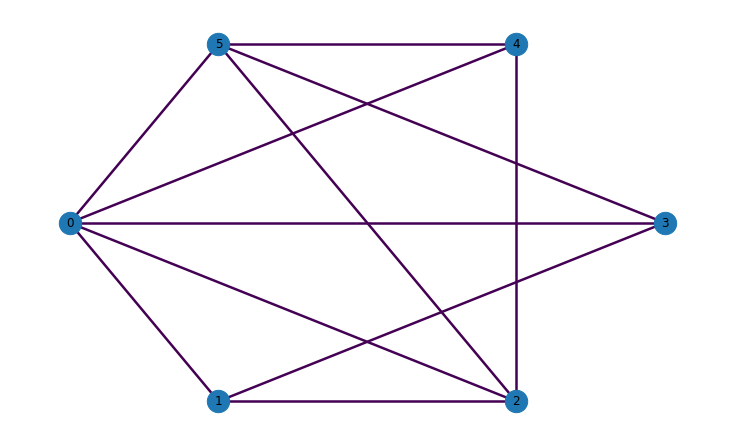

In [102]:
nodes = 6
edge_probability = 0.7
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)
plot_graph(g)

In [123]:
# Brute Force Solution
mini_cov = MinimumVertexCover(g, field = 1., penalty = 1.)
mini_cov_qubo = mini_cov.get_qubo_problem()
energy, configuration = ground_state_hamiltonian(mini_cov_qubo.hamiltonian)
print('Energy: {}'.format(energy), '\nConfigurations: {}'.format(configuration))

Energy: 4.0 
Configurations: ['101100', '101110', '110001', '101001', '111001', '101101', '110011']


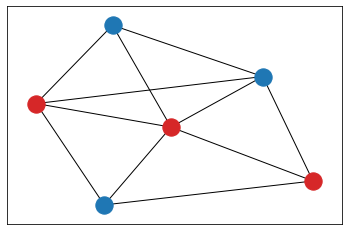

In [104]:
# Possible Solution (Red Nodes represents the Vertex Cover)
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

## Solving the Problem with QAOA

In the standard QAOA, the X-mixer hamiltonian is used.
Using the vectorized backend, we can solve the same problem as follows:

In [129]:
q = QAOA()
q.set_circuit_properties(mixer_hamiltonian = 'x')
q.compile(mini_cov_qubo)

In [130]:
q.optimize()

In [131]:
q.results.most_probable_states

{'solutions_bitstrings': ['101110'], 'bitstring_energy': 4.0}

In [132]:
configuration = q.results.most_probable_states['solutions_bitstrings']

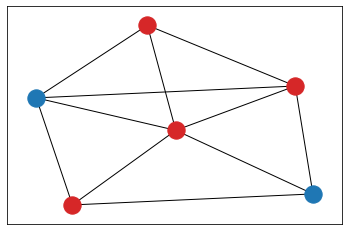

In [133]:
# Plotting the Vectorized Backend Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

## Using A Different Mixer 

OpenQAOA also provides an alternative to the X-mixer, the XY-mixer which utilizes 2-qubit interactions instead of the 1-qubit interactions used for the X-mixer hamiltonian.

In [110]:
q = QAOA()
q.set_circuit_properties(mixer_hamiltonian = 'xy')
q.compile(mini_cov_qubo)

In [111]:
q.optimize()

In [112]:
q.results.most_probable_states

{'solutions_bitstrings': ['100111'], 'bitstring_energy': 5.0}

In [113]:
configuration = q.results.most_probable_states['solutions_bitstrings']

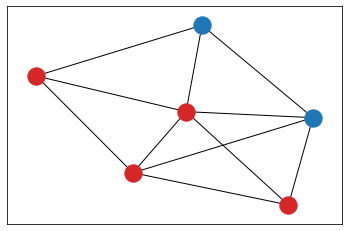

In [114]:
# Plotting the Solution with Default Connectivity of the XY-mixer
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

Since the XY-mixer is made up of 2-qubit interactions, it is possible to change the connectivity of the mixer hamiltonian. By default, this value is "full". Which applies XX and YY interactions between every pair of qubit. Depending on the device connectivity, this may not be the best topology to use.

It may be worth exploring the different pre-defined connectivities.

In [139]:
# mixer_qubit_connectivity: ['full', 'star', 'chain']
q = QAOA()
q.set_circuit_properties(mixer_hamiltonian = 'xy', mixer_qubit_connectivity='chain')
q.compile(mini_cov_qubo)

In [140]:
q.optimize()

In [141]:
q.results.most_probable_states

{'solutions_bitstrings': ['101100'], 'bitstring_energy': 4.0}

In [142]:
configuration = q.results.most_probable_states['solutions_bitstrings']

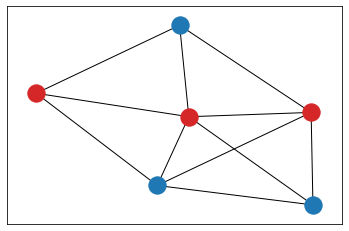

In [143]:
# Plotting the Solution with Star-shaped Connectivity of the XY-mixer
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

nodes = 6
edge_probability = 0.7
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)
plot_graph(g)nodes = 6
edge_probability = 0.7
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)
plot_graph(g)# Quantum Alternating Operator Ansatz

In this notebook, we introduce an algorithm titled the Quantum Alternating Operator Ansatz, QAOA. (Not to be confused with the Quantum Approximation Optimization Algorithm)

## Introduction

The Quantum Alternating Operator Ansatz utilizes the alternating unitary structure of the original QAOA algorithm with a slight generalization. 

The algorithm involves the application of a phase seperation operators, defined by an objective function, and mixing operators that depend on the domain and structure of the objective function. This is a slight departure from the original QAOA algorithm where the mixer unitary is defined by Mixer Hamiltonians, the former allowing for more variations to the mixer unitary.

Since the phase seperator operator depends on the objective function we are trying to optimize over, the cost hamiltonian for a problem can also be used as such an operator.

In the following examples, we show you how you can define your own custom mixer blocks, a block containing gates that would be used to define the mixer unitary, using the OpenQAOA GateMap Objects.The Quantum Alternating Operator Ansatz utilizes the alternating unitary structure of the original QAOA algorithm with a slight generalization. The algorithm still mantains the application of a cost unitary, defined by a cost hamiltonian of the problem, while allowing the user to specify any custom mixer unitary. This is a slight departure from the original QAOA algorithm where the mixer unitary is defined by Mixer Hamiltonians, the former allowing for more variations to the mixer unitary.

## Creating Custom Mixers

In [312]:
# You can specify a custom mixer block using the GateMap Objects
# Using manual mode
from openqaoa.qaoa_parameters.gatemap import RZXGateMap, RXXGateMap
from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.optimizers import get_optimizer
from openqaoa.backends.qaoa_backend import get_qaoa_backend

custom_mixer_block_gatemap = [RZXGateMap(0, 1), RZXGateMap(0, 2), 
                              RZXGateMap(0, 3), RZXGateMap(0, 4), 
                              RZXGateMap(0, 5), RXXGateMap(1, 2)]
custom_mixer_block_coeffs = [1., 1., 1., 1., 1., 1.]

circuit_params = QAOACircuitParams(mini_cov_qubo.hamiltonian, 
                                   custom_mixer_block_gatemap, p=1, 
                                   mixer_coeffs=custom_mixer_block_coeffs)
device_local = create_device(location='local', name='vectorized')
variate_params = create_qaoa_variational_params(circuit_params, 'standard', 'rand')
backend_local = get_qaoa_backend(circuit_params, device_local)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla', 
                                                          'maxiter': 100})

In [313]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 100

In [314]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['110001'], 'bitstring_energy': 4.0}

In [315]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

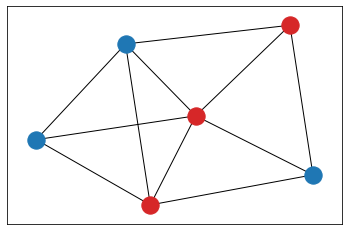

In [316]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

Due to the potential complexity of implementing these mixer blocks, we have added convinience functions in OpenQAOA that builds standard patterns using the supported 2-Qubit GateMaps.

In [317]:
from openqaoa.utilities import quick_create_mixer_for_topology

# This function creates a star pattern mixer block with qubit 0 as its center
# If no coefficients are specified, the function uses default coefficients for
# all gatemaps in it
zx_gatemap_list, zx_gatemap_coeffs = quick_create_mixer_for_topology(RZXGateMap, 6, qubit_connectivity='star')
xx_gatemap_list, xx_gatemap_coeffs = quick_create_mixer_for_topology(RXXGateMap, 6, qubit_connectivity='full')

zx_gatemap_list.extend(xx_gatemap_list)
zx_gatemap_coeffs.extend(xx_gatemap_coeffs)

final_gatemap_list = zx_gatemap_list
final_gatemap_coeffs = zx_gatemap_coeffs

In [318]:
circuit_params = QAOACircuitParams(mini_cov_qubo.hamiltonian, 
                                   final_gatemap_list, p=1, 
                                   mixer_coeffs=final_gatemap_coeffs)
device_local = create_device(location='local', name='vectorized')
variate_params = create_qaoa_variational_params(circuit_params, 'standard', 'rand')
backend_local = get_qaoa_backend(circuit_params, device_local)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla', 
                                                          'maxiter': 100})

In [319]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 100

In [320]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['100001'], 'bitstring_energy': 5.0}

In [321]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

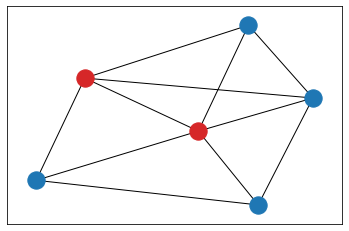

In [322]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

Its also possible to specify the 2-qubit gatemap connections using a networkx graph.

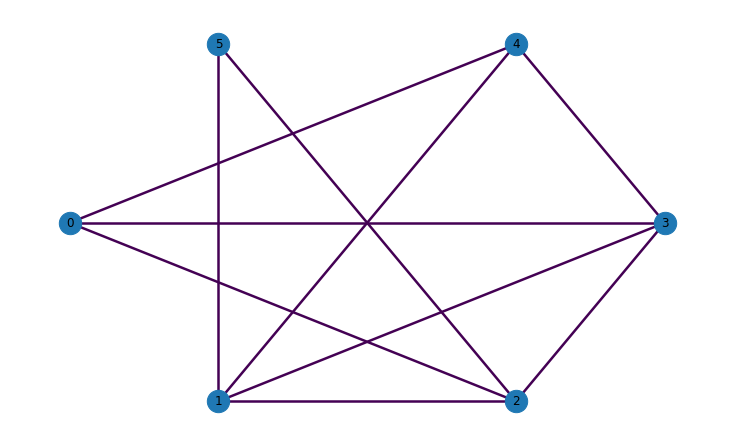

In [344]:
# Create 2-Qubit Connection Graph for Mixer
nodes = 6
edge_probability = 0.7
mixer_g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)
plot_graph(mixer_g)

In [345]:
# Input the EdgeMap into the convinience function
edge_map = [edge for edge in mixer_g.edges()]
edge_coeffs = [1.0]*len(edge_map)
final_gatemap_list, final_gatemap_coeffs = quick_create_mixer_for_topology(RXXGateMap, 6, edge_map, edge_coeffs)

In [346]:
circuit_params = QAOACircuitParams(mini_cov_qubo.hamiltonian, 
                                   final_gatemap_list, p=1, 
                                   mixer_coeffs=final_gatemap_coeffs)
device_local = create_device(location='local', name='vectorized')
variate_params = create_qaoa_variational_params(circuit_params, 'standard', 'rand')
backend_local = get_qaoa_backend(circuit_params, device_local)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla', 
                                                          'maxiter': 100})

In [347]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 100

In [348]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['110110'], 'bitstring_energy': 5.0}

In [349]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

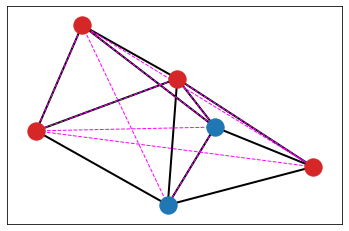

In [354]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos, width=2);
nx.draw_networkx_edges(mixer_g, pos, edge_color=(1, 0, 1), style="--")

Both the problem's connectivity and mixer connectivity superimposed on the same diagram. The pink dotted lines representing the Mixer's connectivity. 

## References

[1] S. Hadfield, Z. Wang, B. O'Gorman, E. Rieffel, D. Venturelli and R. Biswas, (2019), 10.3390/a12020034